In [149]:
import numpy as np
from umap import UMAP
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pd.options.display.max_rows = 10
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
df = pd.read_csv('faults.csv')
df.columns = map(str.lower, df.columns)
binary_features = ['outside_global_index', 'typeofsteel_a300', 'typeofsteel_a400']
numerical_features = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas']
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas']
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']
enc_dict = {'pastry' : 0,
            'z_scratch' : 1,
            'k_scatch' : 2,
            'stains' : 3,
            'dirtiness' : 4,
            'bumps' : 5,
            'other_faults' : 6}
df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
sm = SMOTE(random_state = 2)
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)
df = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)

/tmp/ipykernel_5290/4121746626.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which i

In [150]:
mask = (df['anomaly'] == 5) | (df['anomaly']==6)
df56_old = df[mask]
df56_old.reset_index(inplace = True)

In [151]:
ump = UMAP(n_neighbors = 10, n_components = 20, random_state = 2, n_epochs = 1000)
X = df56_old[feat_col]
X56_ump = ump.fit_transform(X)
df56_ump = pd.DataFrame(X56_ump)
df56_ump['anomaly'] = df56_old['anomaly']

/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [152]:
df_others = df[~mask]
df_others.reset_index(inplace = True)

In [153]:
ump = UMAP(n_neighbors = 10, n_components = 20, random_state = 2)
X = df_others[feat_col]
Xothers_ump = ump.fit_transform(X)
df_others_ump = pd.DataFrame(Xothers_ump)
df_others_ump['anomaly'] = df_others['anomaly']

/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [154]:
df = pd.concat([df56_ump, df_others_ump], axis = 0, ignore_index = True)

In [155]:
ump = UMAP(n_neighbors = 10, n_components = 3, random_state = 2, n_epochs = 1000)
X = df.loc[:, df.columns != 'anomaly']
X_ump = ump.fit_transform(X)
df_ump = pd.DataFrame(X_ump)
df_ump['anomaly'] = df['anomaly']

/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


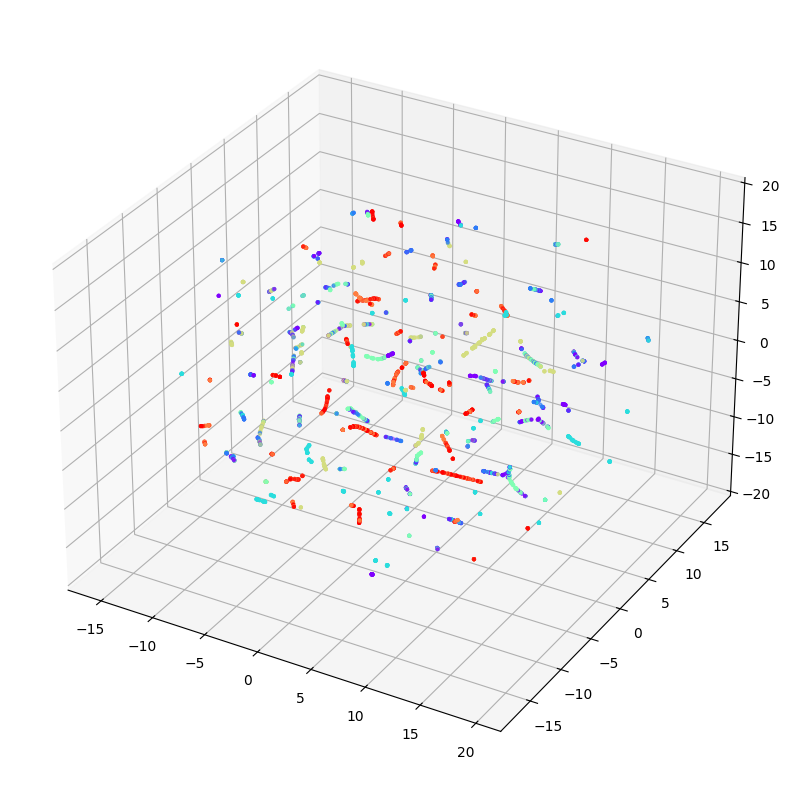

In [156]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')
ax.scatter(df_ump[0], df_ump[1], df_ump[2], c = df_ump['anomaly'], s = 4, cmap = cmap)
plt.show()

In [157]:
ump = UMAP(n_neighbors = 10, n_components = 10, random_state = 2)
X = df.drop('anomaly', axis = 1)
X_ump = ump.fit_transform(X)
df_ump = pd.DataFrame(X_ump)
df_ump['anomaly'] = df['anomaly']

/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [158]:
X = df_ump.drop('anomaly', axis = 1)
y = df_ump['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 2, shuffle = True)

In [159]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [160]:
grid.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

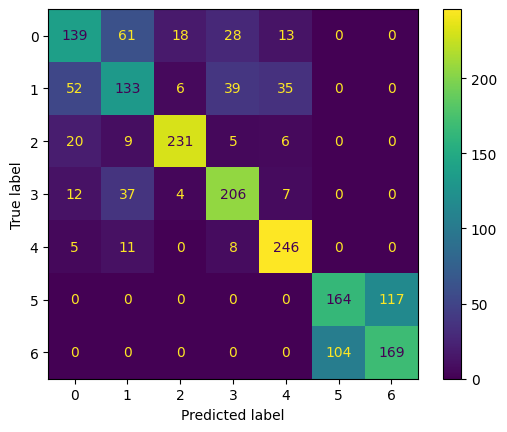

Accuracy score for SVM: 0.68%


In [161]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()
svm_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for SVM: {svm_accuracy}%')

## NN

In [162]:
X = df_ump.drop('anomaly', axis = 1)
y = df_ump['anomaly']
y = tf.keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [163]:
model = Sequential([
    Dense(128, input_dim = X_train.shape[1], activation = 'relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, activation = 'relu'),
    Dropout(0.4),
    Dense(7, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2, verbose = 0)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

/home/dario/Università/Data_science/Secondo_anno-primo_semestre/Machine_learning/UNIVR-machinelearning/venv/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6337 - loss: 0.8536 
Test Accuracy: 0.63


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


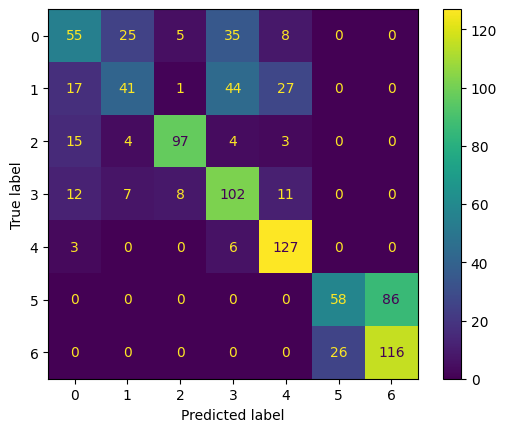

Accuracy score for NN: 0.63%


In [164]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()
nn_accuracy = round(accuracy_score(y_test, y_pred), 2)
print(f'Accuracy score for NN: {nn_accuracy}%')